# Model Analysis

## Import Modules

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

## RunParameters Class

In [2]:
class RunParameters:
    '''classe che gestisce i parametri della run'''
    
    def __init__(self, out_dir: str, ndir=0, ntoy=40, magic=0):
        '''init: imposto il nome della cartella di output, genero il nome della cartella contenente il file e cerco il file'''
        
        # output directory
        self.out_dir = out_dir
        # entro nella output directory e dentro alla cartella con il numero magico del toy
        # prendo come folder_name il nome della cartella indicizzata da ndir
        self.folder_name = os.listdir(self.out_dir+f'/{magic}/')[ndir]
        # costruisco il nome del file contenente i t
        self.fname = [name for name in os.listdir(self.out_dir+f'/{magic}/'+self.folder_name) if f'_toy{ntoy}_t.txt' in name][0]
        
        return
    
    def fetch_parameters(self) -> list:
        '''uso il nome del file e della cartella per estrarre i parametri della run'''
        
        # estrazione dei parametri della run da fname e folder_name
        self.check_point_t = int(self.fname.split("patience", 1)[1].split("_", 1)[0])
        self.toys = int(self.fname.split("toy", 1)[1].split("_", 1)[0])
        self.ref = (self.fname.split("_")[2]).split("ref")[1]
        self.bkg = (self.fname.split("_")[3]).split("bkg")[1]
        self.sig = (self.fname.split("_")[4]).split("sig")[1]
        self.w_clip = self.folder_name.split('wclip',1)[1]
        self.latent = int(self.folder_name.split("latent", 1)[1].split("_", 1)[0])
        self.layers = int(self.folder_name.split("layers", 1)[1].split("_", 1)[0])
        self.epochs = int(self.folder_name.split('epochs',1)[1].split('_')[0])
        
        # impacchetto i parametri in una lista da ritornare
        self.parameters = [self.toys, self.w_clip, self.epochs, self.check_point_t, self.ref, self.bkg, self.sig, self.latent, self.layers]
        
        return self.parameters
    
    def print_parameters(self):
        '''stampo i parametri per controllare corrispondano alla run'''
        
        print('\nFolder name: ' + self.folder_name)
        print('File name: ' + self.fname)
        
        print(f'\nParameters:                                              \
                        \n Toys:          {self.toys}                      \
                        \n Latent space:  {self.latent}                    \
                        \n Layers:        {self.layers}                    \
                        \n W_clip:        {self.w_clip}                    \
                        \n Epochs:        {self.epochs}                    \
                        \n Check_point_t: {self.check_point_t}             \
                        \n Ref, Bkg, Sig: {self.ref} {self.bkg} {self.sig} \n'
             )
        
        return  
    
    def fetch_file(self) -> str:
        '''genero il nome completo del file contenente il t finale'''
        
        self.tfile = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_t.txt'
        
        # tolgo gli spazi vuoti che vengono automaticamente inseriti andando a capo con \
        self.tfile = self.tfile.replace(' ', '')
        
        return self.tfile
    
    def fetch_history(self) -> str:
        '''genero il nome completo del file contenente il t per ogni checkpoint'''
        
        self.thistory = f'1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}\
        _epochs{self.epochs}_latent{self.latent}_layers{self.layers}_wclip{self.w_clip}\
        /1D_patience{self.check_point_t}_ref{self.ref}_bkg{self.bkg}_sig{self.sig}_toy{self.toys}_history{self.check_point_t}.h5'
        
        # tolgo gli spazi vuoti che vengono automaticamente inseriti andando a capo con \
        self.thistory = self.thistory.replace(' ', '')
        
        return self.thistory

## T Distribution Class

In [49]:
class TDist:
    '''classe che gestisce la distribuzione dei t'''
    
    def __init__(self, dof, bins, toys, epochs, check_point_t, out_dir, tfile, thistory):
        '''init: imposto parametri importanti della run e i file di interesse'''
        
        self.dof = dof
        self.bins = bins
        self.epochs = epochs
        self.check_point_t = check_point_t
        self.toys = toys
        self.OUT_PATH = out_dir
        self.OUT_FILE_t = tfile
        self.OUT_FILE_t_history = thistory
        
        return
    
    
    def plotOutPath(self):
        '''costruisco il percorso di salvataggio delle figure'''
        
        path = '/lustre/cmswork/nlai/PLOTS/MODEL_SELECTION/'
        rPar = RunParameters(self.OUT_PATH, 0, self.toys)
        toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
        
        pngfile = f'1D_patience{check_point_t}_ref{ref}_bkg{bkg}_sig{sig}\
        _epochs{epochs}_latent{latent}_layers{layers}_wclip{w_clip}_toy{toys}'
        
        pngfile = pngfile.replace(' ', '')
        
        self.pngpath = path + pngfile
        
        return self.pngpath
    
    
    def getT(self):
        '''ciclo su tutti i file per prendere tutti i t e tutte le history'''
        
        # inizializzo le liste
        self.t_list=[]
        self.t_list_history=[]
        
        counter=0
        preview=0
        
        # ciclo su tutti i toy
        for i in range(self.toys-preview):
            
            # entro nella output directory, numero magico del toy i-esimo, e prendo il file t
            file_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t
            
            # controllo se è effettivamente un file esistente
            if os.path.isfile(file_name):
                # apro il file in read mode
                f = open(file_name, "r")
                # leggo cosa c'è scritto e lo inserisco nella lista
                self.t_list.append(float(f.readline()[:-1]))
                # chiudo il file
                f.close()
                #print(i)
                # modo stranissimo per dire che se è andato tutto bene allora aumento il counter
                if np.logical_not(np.isnan(self.t_list[-1])):
                    counter += 1
            
            # entro nella output directory, numero magico del toy i-esimo, e prendo il file con la storia di t
            history_name = self.OUT_PATH + f'/{i}/' + self.OUT_FILE_t_history
            
            # controllo se è effettivamente un file esistente
            if os.path.isfile(history_name):
                # apro il file in read mode
                f = h5py.File(history_name, "r")
                # leggo cosa c'è scritto e lo inserisco nella lista
                try:
                    self.t_list_history.append(-2*np.array(f.get('loss')))
                except: 
                    print('Problem with toy ', i)
                # chiudo il file
                f.close()
        
        # converto in numpy array 
        self.t_list=np.array(self.t_list)
        self.t_list_history=np.array(self.t_list_history)
        
        print(f"\nToys at disposal/Total toys: {counter}/{self.toys-preview}")
        
        return 
    
    
    def computeMedian(self):
        '''calcolo la mediana per un rapido controllo di compatibilità'''
        
        # calcolo la mediana della lista
        median_t = np.median(self.t_list)
        print("\nMedian t distribution: ", median_t)
        
        # calcolo il p-value della lista 
        p_list = np.sum([1/(len(self.t_list)) for x in self.t_list if x>median_t])
        print(
            f"Median p-value: {p_list :.4f}\
            Median significance: {scipy.stats.norm.ppf(1-p_list):.4f}\
            from t list"
        )
        
        print(
            f"Median p-value: {scipy.stats.chi2.sf(median_t, df=self.dof):.4f}\
            Median significance: {scipy.stats.norm.ppf(1-scipy.stats.chi2.sf(median_t, df=self.dof)):.4f}\
            from chi2 distribution" 
        ) 
        # df = 96 nella seconda
        
        return
    
    
    def change_legend(self, ax, new_loc, fontsize, titlesize, **kws):
        '''funzione per modificare posizione e font size della legenda generata da seaborn'''

        old_legend = ax.legend_
        handles = old_legend.legendHandles
        labels = [t.get_text() for t in old_legend.get_texts()]
        title = old_legend.get_title().get_text()

        ax.legend(handles, labels, loc=new_loc, title=title, 
                  fontsize=fontsize, title_fontsize=titlesize, 
                  frameon = True, fancybox = False, framealpha = 0.5, **kws)
    
        return
    
    
    def plotTdist(self):
        '''grafico della distribuzione dei t'''
        
        # gestione del plot range
        XMIN = 0
        if max(self.t_list) >= 3*self.dof:
            XMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            XMAX = 3*self.dof
        
        # creo la griglia lungo x
        XGRID = np.linspace(XMIN, XMAX, 500)
        
        # numero di bin da utilizzare
        BINS = self.bins
        
        # fit della distribuzione con un chi2
        fit_par = scipy.stats.chi2.fit(self.t_list, floc=0, fscale=1)
        
        # creo figure&axes
        fig, ax = plt.subplots(figsize=(12,7))
        
        # istogramma della distrubuzione dei t
        ax = sns.histplot(x=self.t_list, bins=BINS, 
                          stat='density', element='bars', fill=True, color='#aadeff', edgecolor='#009cff', 
                          label='t distribution')
        
        # parte di codice per aggiungere l'incertezza ai bin 
        hist, bin_edges = np.histogram(self.t_list, density=True, bins=BINS)
        binswidth = bin_edges[1]-bin_edges[0]
        central_points = []
        for i in range(0, len(bin_edges)-1):
            half = (bin_edges[i] + bin_edges[i+1])/2
            central_points.append(half)
        # calcolo dell'incertezza dei bin
        err = np.sqrt(hist/(self.t_list.shape[0]*binswidth))
        # grafico delle incertezze sui bin 
        ax.errorbar(central_points, hist, yerr = err, color='#009cff', marker='o', ls='')
        
        # grafico della distribuzione teorica del chi2
        ax.plot(XGRID,scipy.stats.chi2.pdf(XGRID, df=self.dof), 
                color='#00FF00', linestyle='solid', linewidth=5, alpha=0.6, 
                label=f'theoretical distribution, dof: {self.dof}')
        
        # grafico del fit della distribuzione 
        ax.plot(XGRID, scipy.stats.chi2.pdf(XGRID, *fit_par), 
                color='#FF0000', linestyle='solid', linewidth=5, alpha=0.6, 
                label=f'fitted chi2, dof: '+format(fit_par[0],'1.4f'))
        
        # titolo figura e assi
        ax.set_title('t distribution', fontsize = 18)
        ax.set_xlabel('t', fontsize = 16)
        ax.set_ylabel('density', fontsize = 16)
        
        # sistemo i ticks
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        # plot range
        ax.set_xlim(XMIN, XMAX)
        
        # gestione della legenda
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[idx] for idx in [2, 0, 1]], [labels[idx] for idx in [2, 0, 1]])
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tdist_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return 
    
    
    def plotThistory(self):
        '''grafico della storia dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        for i in range(len(self.t_list_history)):
            ax.plot(x_tics[1:],self.t_list_history[i][1:])
            
        ax.set_title('t history', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('t', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_thistory_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotQuantilesEvo(self):
        '''grafico dell'evoluzione dei quantili della distribuzione dei t'''
        
        XMIN = 0
        XMAX = self.epochs
        
        YMIN = 0
        if max(self.t_list) >= 3*self.dof:
            YMAX = max(self.t_list) + min(self.t_list) 
        elif max(self.t_list) < 3*self.dof:
            YMAX = 3*self.dof
        
        fig, ax = plt.subplots(figsize=(12,7))
        
        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0]
        
        quantile_list = [0.05,0.25,0.50,0.75,0.95]
        color_list = ['#ff0000', '#00ff00', '#0080ff', '#ff8000', '#ff00ff']
        th_quantile_position = [scipy.stats.chi2.ppf(i,df=self.dof) for i in quantile_list]
        t_quantile = np.quantile(self.t_list_history, quantile_list, axis=0)
        
        for i in range(len(quantile_list)):
            ax.plot(x_tics[1:], t_quantile[i][1:], 
                    color = color_list[i], linestyle='solid', linewidth = 3, 
                    label = format(quantile_list[i], '1.2f'))
            ax.plot(x_tics[-1], th_quantile_position[i], marker='X', markersize = 15,
                    color = color_list[i])
            ax.hlines(y=th_quantile_position[i], xmin = XMIN, xmax = XMAX, 
                      color = color_list[i], linestyle='dashed', linewidth = 3, alpha = 0.5, 
                    label = 'theoretical ' + format(quantile_list[i], '1.2f'))
        ax.set_title('t quantiles evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('t', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        ax.legend(title = 'Quantiles', ncol = 2)
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        ax.legend(title = 'Quantiles', ncol = 2)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tquantiles_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        return
    
    
    def plotChi2History(self):
        self.t_chi2_history = []
        bin_number = self.bins 
        
        for counter in range(10, self.t_list_history.shape[1]): 
            # binning della distribuzione dei t per ogni checkpoint
            t_hist, binedges = np.histogram(self.t_list_history[:, counter], bins=bin_number, density=False) 
            # cerco il centro di ciascun bin
            bincenter = np.array([(binedges[i+1]+binedges[i])/2 for i in range(len(t_hist))])
            # calcolo l'altezza teorica di ciascun bin
            
            '''
            devo integrare il chi2 nel bin - posso farlo sottraendo i pvalue per ciascun bin! ora è assunt uniforme (chi2 a gradini)
            '''
            th_bins = np.array([(binedges[1]-binedges[0])*self.toys*scipy.stats.chi2.pdf(b_center, df=self.dof) for b_center in bincenter])
            # calcolo il chi2
            self.t_chi2_history.append( np.sum( (t_hist-th_bins)**2/th_bins, axis=0 ) ) 
    
        XMIN = 0
        XMAX = self.epochs

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0][10:]

        
        ax.plot(x_tics[:], self.t_chi2_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'chi2 final value: {self.t_chi2_history[-1]:.3f}')
        
        ax.set_title('chi2 evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('chi2', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        ax.set_yscale('log')
        
        ax.set_xlim(XMIN, XMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tchi2_hstat.png', dpi = 300, facecolor='white')
        plt.show()

        
        return
    
    
    def plotChi2Compatibility(self):
        
        bin_number = self.bins 
        
        self.t_chi2_compatibility = np.array(self.t_chi2_history)/(bin_number-1)
    
        XMIN = 0
        XMAX = self.epochs

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % self.check_point_t == 0][10:]
        
        ax.plot(x_tics[:], self.t_chi2_compatibility[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'lambda final value: {self.t_chi2_compatibility[-1]:.3f}'
               )
        
        ax.set_title('compatibility evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('lambda', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
#         ax.set_yscale('log')
        
        ax.set_xlim(XMIN, XMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
        
        plt.show()
        
        return
    
    
    def plotPValHistory(self):
        
        bin_number = self.bins
        self.pvalue_history=scipy.stats.chi2.sf(self.t_chi2_history[:], df=bin_number-1) # 20-1????????

        XMIN = 0
        XMAX = self.epochs
        YMIN = 0
        YMAX = 1.2

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
        y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.pvalue_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'p-val final value: {self.pvalue_history[-1]:.3f}')
        
        ax.set_title('p-value evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('p-value', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
        ax.set_yticks(y_tics)
        
        ax.set_xlim(XMIN, XMAX)
        ax.set_ylim(YMIN, YMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tpval_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        
        return
    
    
    def plotSignificanceHistory(self):
        
        bin_number = self.bins
        self.significance_history=scipy.stats.norm.ppf(1-self.pvalue_history[:])

        XMIN = 0
        XMAX = self.epochs
#         YMIN = 0
#         YMAX = max(self.significance_history)+min(self.significance_history)

        fig, ax = plt.subplots(figsize=(12,7))

        x_tics = np.array(range(self.epochs))
        x_tics = x_tics[x_tics % check_point_t == 0][10:]
#         y_tics = np.array( np.arange(0, 1.1, 0.1) )
        
        ax.plot(x_tics[:], self.significance_history[:], color='#009cff', linestyle='solid', linewidth=3, alpha=1, 
                label=f'significance final value: {self.significance_history[-1]:.3f}')
        
        ax.set_title('significance evolution', fontsize = 18)
        ax.set_xlabel('training epoch', fontsize = 16)
        ax.set_ylabel('significance', fontsize = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)
#         ax.set_yticks(y_tics)
        
        ax.set_xlim(XMIN, XMAX)
#         ax.set_ylim(YMIN, YMAX)
        
        ax.legend()
        self.change_legend(ax=ax, new_loc="upper right", fontsize=14, titlesize=16)
        
        fig.tight_layout()
#         fig.savefig(self.plotOutPath()+'_tpval_hstat.png', dpi = 300, facecolor='white')
        plt.show()
        
        return


## Check Run Parameters

In [8]:
WCLIP = 7 # MODIFY THIS FOR CHANGING DIRECTORY
NTOYS = 150

EPOCHS = '200k'
JOB = '_hstat' # '_hstat'


DATA_FOLDER = '/lustre/cmswork/nlai/NPL_1D/MODEL_SELECTION/'
OUT_PATH = DATA_FOLDER + f'E{EPOCHS}W{WCLIP}{JOB}'
DOF = 10
NFOLDER = 0

rPar = RunParameters(OUT_PATH, NFOLDER, NTOYS)
toys, w_clip, epochs, check_point_t, ref, bkg, sig, latent, layers = rPar.fetch_parameters()
rPar.print_parameters()

OUT_FILE_t = rPar.fetch_file()
OUT_FILE_t_history = rPar.fetch_history()


Folder name: 1D_patience1000_ref200000_bkg10000_sig0_epochs200000_latent3_layers1_wclip7.0
File name: 1D_patience1000_ref200000_bkg10000_sig0_toy150_t.txt

Parameters:                                                                      
 Toys:          150                                              
 Latent space:  3                                            
 Layers:        1                                            
 W_clip:        7.0                                            
 Epochs:        200000                                            
 Check_point_t: 1000                                     
 Ref, Bkg, Sig: 200000 10000 0 



## Model Analysis


Toys at disposal/Total toys: 150/150

Median t distribution:  9.5314175
Median p-value: 0.5000            Median significance: 0.0000            from t list
Median p-value: 0.4825            Median significance: 0.0438            from chi2 distribution


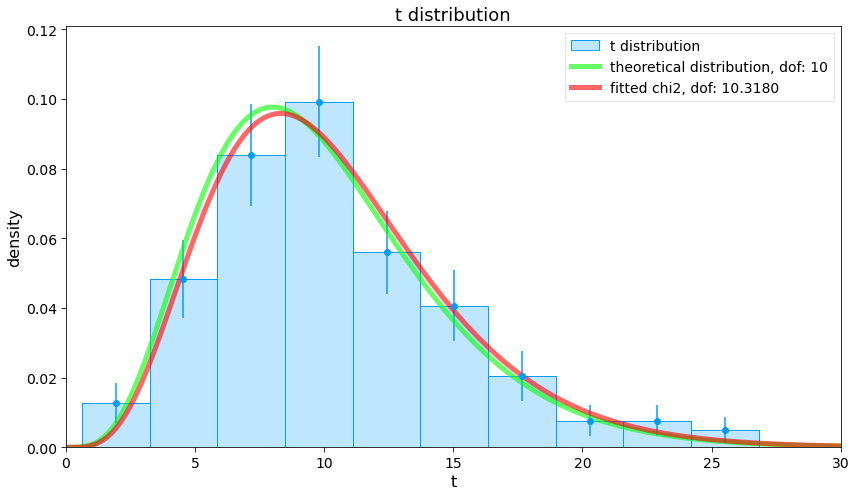

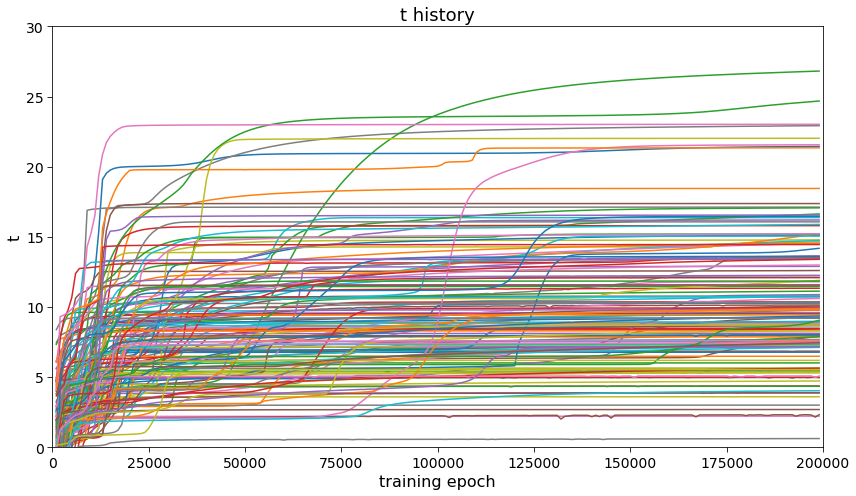

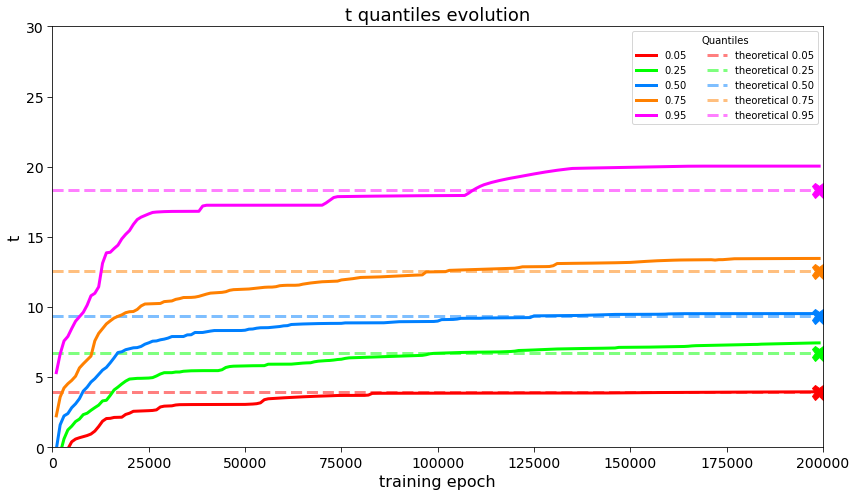

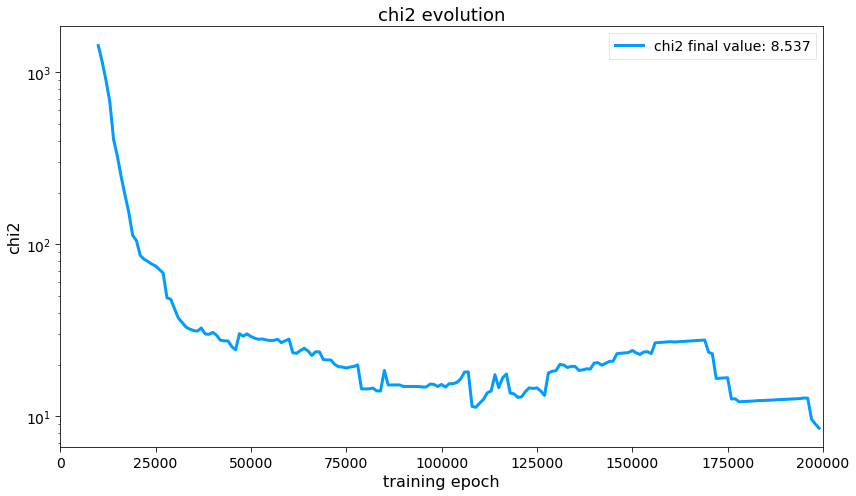

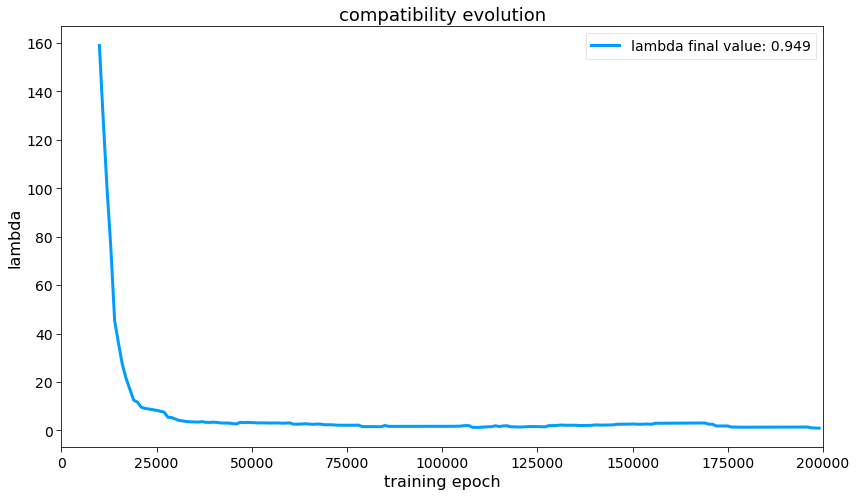

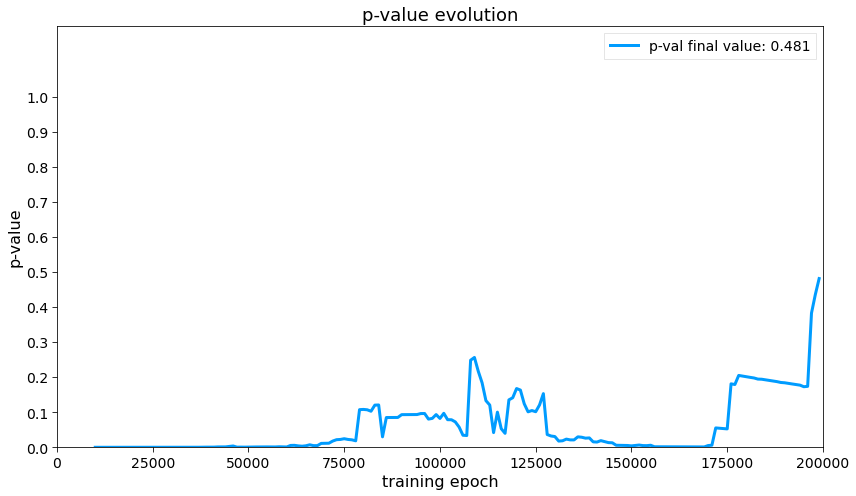

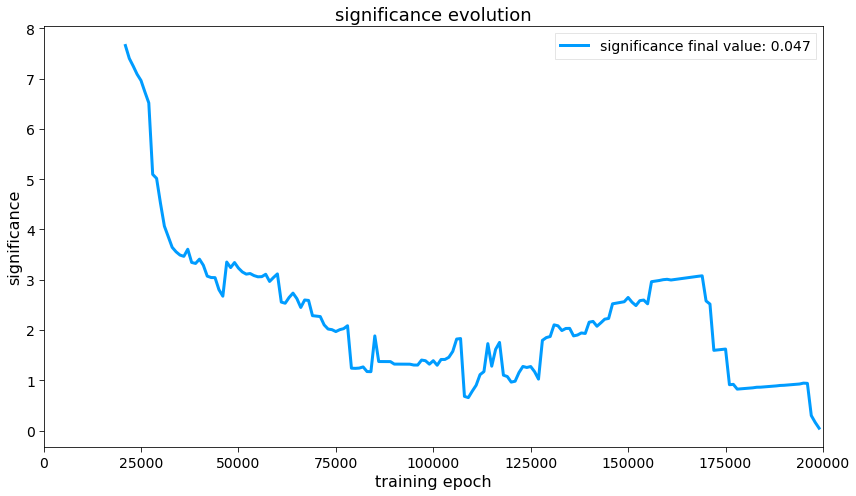

In [51]:
BINS = 10

tDist = TDist(DOF, BINS, toys, epochs, check_point_t, OUT_PATH, OUT_FILE_t, OUT_FILE_t_history)
tDist.getT()
tDist.computeMedian()

tDist.plotTdist()
tDist.plotThistory()
tDist.plotQuantilesEvo()
tDist.plotChi2History()
tDist.plotChi2Compatibility()
tDist.plotPValHistory()
tDist.plotSignificanceHistory()

In [6]:
tDist.t_list_history.shape

(150, 200)